In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing

In [2]:
# transform a timeseries dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
            # put it all together
    agg = pd.concat(cols, axis=1)
        # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
# load the dataset
path = './IC00.xls'
file = pd.read_excel(path)
values = file.loc[:, 'C_'].values
values = values.reshape(-1,1)
# transform the timeseries data into supervised learning
values.shape

(10848, 1)

In [4]:
# 用来归一化
scaler = preprocessing.MinMaxScaler().fit(values)
values = scaler.transform(values)

In [5]:
train = series_to_supervised(values, n_in=30)
# split into input andoutput columns
trainX, trainy =train[:, :-1], train[:, -1].reshape(-1,1)
trainX.shape,trainy.shape

((10818, 30), (10818, 1))

In [6]:
trainX.shape,trainy.shape

((10818, 30), (10818, 1))

In [7]:
trainX[:5],trainy[:5]

(array([[0.15640731, 0.16691698, 0.17348319, 0.1713627 , 0.16740063,
         0.16855388, 0.15889987, 0.16195046, 0.16732621, 0.16924215,
         0.17519452, 0.17078602, 0.1811655 , 0.17722204, 0.17232994,
         0.17737084, 0.17889616, 0.17201375, 0.17179047, 0.16799586,
         0.17588273, 0.17361338, 0.17430164, 0.16479649, 0.16260151,
         0.15955093, 0.15936492, 0.16635896, 0.17216249, 0.17199509],
        [0.16691698, 0.17348319, 0.1713627 , 0.16740063, 0.16855388,
         0.15889987, 0.16195046, 0.16732621, 0.16924215, 0.17519452,
         0.17078602, 0.1811655 , 0.17722204, 0.17232994, 0.17737084,
         0.17889616, 0.17201375, 0.17179047, 0.16799586, 0.17588273,
         0.17361338, 0.17430164, 0.16479649, 0.16260151, 0.15955093,
         0.15936492, 0.16635896, 0.17216249, 0.17199509, 0.182635  ],
        [0.17348319, 0.1713627 , 0.16740063, 0.16855388, 0.15889987,
         0.16195046, 0.16732621, 0.16924215, 0.17519452, 0.17078602,
         0.1811655 , 0.17722204,

#  数据模块

In [8]:
class DiabetesDataset(Dataset):
    def __init__(self, x_, y_):
        self.len = x_.shape[0]
        self.x_data = torch.from_numpy(x_)
        # 这部很关键， 特征类型要求float类型
        self.x_data = self.x_data.float()
        self.y_data = torch.from_numpy(y_)
        self.y_data = self.y_data.float()
        

    def __getitem__(self, item):
        return self.x_data[item], self.y_data[item]

    def __len__(self):
        return self.len

In [9]:
dataset = DiabetesDataset(trainX, trainy)
train_loader = DataLoader(dataset=dataset, batch_size=512, shuffle=False)

# 网络结构

In [10]:
# input_size 输入特征的大小
# hidden_size 神经元模块额数量
# num_layer 几层隐藏层
# lstm默认输入的维度是 (seq_len,batch,feature)
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size = 1,
            hidden_size = 64,
            num_layers = 1,
            batch_first = True
        )
        self.out = nn.Linear(in_features = 64,out_features = 1)
    def forward(self, x):
        output,(h_n,c_n) = self.lstm(x)
        out = self.out(output[:,-1,:])
        return out

In [11]:
device = torch.device('cuda')
model = LSTM().to(device)

# 训练

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
total_step = len(train_loader)
epochs = 200
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,30,1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        #rint(outputs.shape,labels.shape)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0 :
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))

Epoch [1/200], Step [5/22], Loss: 0.1135
Epoch [1/200], Step [10/22], Loss: 0.2580
Epoch [1/200], Step [15/22], Loss: 0.0178
Epoch [1/200], Step [20/22], Loss: 0.0256
Epoch [2/200], Step [5/22], Loss: 0.0846
Epoch [2/200], Step [10/22], Loss: 0.0238
Epoch [2/200], Step [15/22], Loss: 0.0008
Epoch [2/200], Step [20/22], Loss: 0.0739
Epoch [3/200], Step [5/22], Loss: 0.0054
Epoch [3/200], Step [10/22], Loss: 0.0122
Epoch [3/200], Step [15/22], Loss: 0.0183
Epoch [3/200], Step [20/22], Loss: 0.0079
Epoch [4/200], Step [5/22], Loss: 0.0387
Epoch [4/200], Step [10/22], Loss: 0.0030
Epoch [4/200], Step [15/22], Loss: 0.0108
Epoch [4/200], Step [20/22], Loss: 0.0209
Epoch [5/200], Step [5/22], Loss: 0.0207
Epoch [5/200], Step [10/22], Loss: 0.0029
Epoch [5/200], Step [15/22], Loss: 0.0126
Epoch [5/200], Step [20/22], Loss: 0.0119
Epoch [6/200], Step [5/22], Loss: 0.0236
Epoch [6/200], Step [10/22], Loss: 0.0021
Epoch [6/200], Step [15/22], Loss: 0.0078
Epoch [6/200], Step [20/22], Loss: 0.012

Epoch [49/200], Step [10/22], Loss: 0.0000
Epoch [49/200], Step [15/22], Loss: 0.0001
Epoch [49/200], Step [20/22], Loss: 0.0001
Epoch [50/200], Step [5/22], Loss: 0.0001
Epoch [50/200], Step [10/22], Loss: 0.0000
Epoch [50/200], Step [15/22], Loss: 0.0001
Epoch [50/200], Step [20/22], Loss: 0.0001
Epoch [51/200], Step [5/22], Loss: 0.0001
Epoch [51/200], Step [10/22], Loss: 0.0000
Epoch [51/200], Step [15/22], Loss: 0.0001
Epoch [51/200], Step [20/22], Loss: 0.0001
Epoch [52/200], Step [5/22], Loss: 0.0001
Epoch [52/200], Step [10/22], Loss: 0.0000
Epoch [52/200], Step [15/22], Loss: 0.0001
Epoch [52/200], Step [20/22], Loss: 0.0001
Epoch [53/200], Step [5/22], Loss: 0.0001
Epoch [53/200], Step [10/22], Loss: 0.0000
Epoch [53/200], Step [15/22], Loss: 0.0001
Epoch [53/200], Step [20/22], Loss: 0.0001
Epoch [54/200], Step [5/22], Loss: 0.0001
Epoch [54/200], Step [10/22], Loss: 0.0000
Epoch [54/200], Step [15/22], Loss: 0.0001
Epoch [54/200], Step [20/22], Loss: 0.0001
Epoch [55/200], 

Epoch [97/200], Step [15/22], Loss: 0.0001
Epoch [97/200], Step [20/22], Loss: 0.0001
Epoch [98/200], Step [5/22], Loss: 0.0001
Epoch [98/200], Step [10/22], Loss: 0.0000
Epoch [98/200], Step [15/22], Loss: 0.0001
Epoch [98/200], Step [20/22], Loss: 0.0001
Epoch [99/200], Step [5/22], Loss: 0.0001
Epoch [99/200], Step [10/22], Loss: 0.0000
Epoch [99/200], Step [15/22], Loss: 0.0001
Epoch [99/200], Step [20/22], Loss: 0.0001
Epoch [100/200], Step [5/22], Loss: 0.0001
Epoch [100/200], Step [10/22], Loss: 0.0000
Epoch [100/200], Step [15/22], Loss: 0.0001
Epoch [100/200], Step [20/22], Loss: 0.0001
Epoch [101/200], Step [5/22], Loss: 0.0001
Epoch [101/200], Step [10/22], Loss: 0.0000
Epoch [101/200], Step [15/22], Loss: 0.0001
Epoch [101/200], Step [20/22], Loss: 0.0001
Epoch [102/200], Step [5/22], Loss: 0.0001
Epoch [102/200], Step [10/22], Loss: 0.0000
Epoch [102/200], Step [15/22], Loss: 0.0001
Epoch [102/200], Step [20/22], Loss: 0.0001
Epoch [103/200], Step [5/22], Loss: 0.0001
Epoc

Epoch [144/200], Step [15/22], Loss: 0.0027
Epoch [144/200], Step [20/22], Loss: 0.0015
Epoch [145/200], Step [5/22], Loss: 0.0017
Epoch [145/200], Step [10/22], Loss: 0.0003
Epoch [145/200], Step [15/22], Loss: 0.0002
Epoch [145/200], Step [20/22], Loss: 0.0009
Epoch [146/200], Step [5/22], Loss: 0.0035
Epoch [146/200], Step [10/22], Loss: 0.0006
Epoch [146/200], Step [15/22], Loss: 0.0044
Epoch [146/200], Step [20/22], Loss: 0.0013
Epoch [147/200], Step [5/22], Loss: 0.0018
Epoch [147/200], Step [10/22], Loss: 0.0002
Epoch [147/200], Step [15/22], Loss: 0.0001
Epoch [147/200], Step [20/22], Loss: 0.0004
Epoch [148/200], Step [5/22], Loss: 0.0016
Epoch [148/200], Step [10/22], Loss: 0.0004
Epoch [148/200], Step [15/22], Loss: 0.0022
Epoch [148/200], Step [20/22], Loss: 0.0004
Epoch [149/200], Step [5/22], Loss: 0.0004
Epoch [149/200], Step [10/22], Loss: 0.0001
Epoch [149/200], Step [15/22], Loss: 0.0001
Epoch [149/200], Step [20/22], Loss: 0.0001
Epoch [150/200], Step [5/22], Loss: 0

Epoch [191/200], Step [20/22], Loss: 0.0002
Epoch [192/200], Step [5/22], Loss: 0.0006
Epoch [192/200], Step [10/22], Loss: 0.0000
Epoch [192/200], Step [15/22], Loss: 0.0003
Epoch [192/200], Step [20/22], Loss: 0.0003
Epoch [193/200], Step [5/22], Loss: 0.0004
Epoch [193/200], Step [10/22], Loss: 0.0001
Epoch [193/200], Step [15/22], Loss: 0.0001
Epoch [193/200], Step [20/22], Loss: 0.0003
Epoch [194/200], Step [5/22], Loss: 0.0007
Epoch [194/200], Step [10/22], Loss: 0.0000
Epoch [194/200], Step [15/22], Loss: 0.0004
Epoch [194/200], Step [20/22], Loss: 0.0004
Epoch [195/200], Step [5/22], Loss: 0.0005
Epoch [195/200], Step [10/22], Loss: 0.0001
Epoch [195/200], Step [15/22], Loss: 0.0002
Epoch [195/200], Step [20/22], Loss: 0.0003
Epoch [196/200], Step [5/22], Loss: 0.0008
Epoch [196/200], Step [10/22], Loss: 0.0000
Epoch [196/200], Step [15/22], Loss: 0.0004
Epoch [196/200], Step [20/22], Loss: 0.0004
Epoch [197/200], Step [5/22], Loss: 0.0005
Epoch [197/200], Step [10/22], Loss: 0

# 预测

In [21]:
predicted = model(torch.FloatTensor(trainX.reshape(-1,30,1)).to(device))

In [22]:
predicted.shape,trainy.shape

(torch.Size([10818, 1]), (10818, 1))

In [23]:
import matplotlib.pyplot as plt

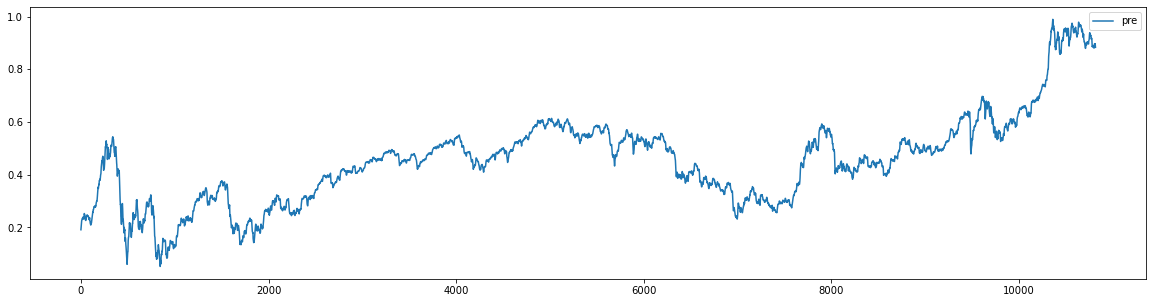

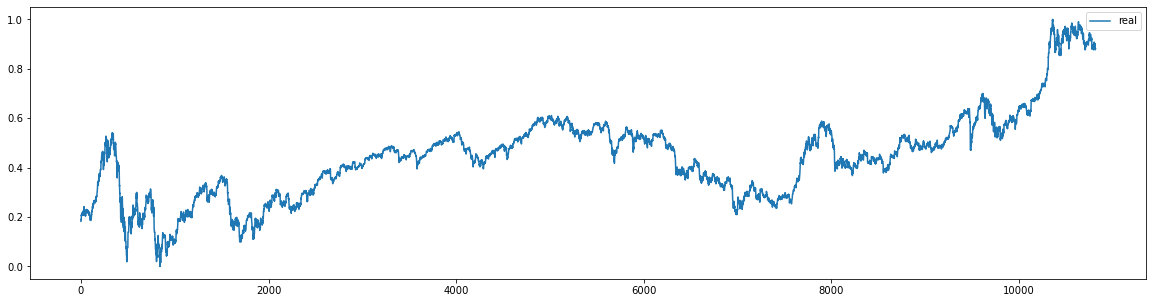

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(predicted.cpu().detach().numpy(),label='pre')
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(20, 5))
plt.plot(trainy,label = 'real')
plt.legend(loc='best')

In [25]:
predicted.cpu().detach().numpy()

array([[0.19068772],
       [0.19533259],
       [0.19963819],
       ...,
       [0.8899722 ],
       [0.8845979 ],
       [0.88305986]], dtype=float32)

In [26]:
trainy

array([[0.182635  ],
       [0.18557401],
       [0.19050332],
       ...,
       [0.87672423],
       [0.88369479],
       [0.88244011]])

# 保存模型

In [27]:
path = './lst_ft.pth'
torch.save(model.state_dict(),path)